# Machine Learning LAB 1: MODEL SELECTION

Course 2024/25: *F. Chiariotti*

The notebook contains a simple learning task over which we will implement **MODEL SELECTION AND VALIDATION**.

Complete all the **required code sections** and **answer all the questions**.

### IMPORTANT for the exam:

The functions you might be required to implement in the exam will have the same signature and parameters as the ones in the labs

## Polynomial Classification on Signal to Noise Ratios

In this notebook we are going to explore the use of polynomial classification with polynomial regression. We are going to use the Numpy **polyfit** function, which performs polynomial regression.

Our use case is a communication problem: we have a set of measurements of the Signal to Noise Ratio (SNR), i.e., the quality of the communication link, in various positions. The SNR depends on two components: firstly, the noise level (which is a random variable that does not depend on position) and the signal attenuation (usually modeled as a polynomial function of the distance).

Our transmitter is in (0,0), and coordinates are in meters. In urban scenarios, the attenuation usually follows a third-degree polynomial, but it might be a fourth- or fifth-degree polynomial in more complex cases. How do we choose between different degrees? We will try with a maximum of **6**

---

## Import all the necessary Python libraries

In [199]:
import numpy as np
import random
import scipy as sp
import pandas as pd
import itertools
from matplotlib import pyplot as plt

---

## Load the data

In this case, x and y are the two coordinates, and the SNR is the thing we are trying to predict

**DO NOT CHANGE THE PRE-WRITTEN CODE UNLESS OTHERWISE SPECIFIED**

In [200]:
df = pd.read_csv('MachineLearning_course\lab1\data\snr_measurements.csv',sep=';')
x = df['x'].to_numpy()
y = df['y'].to_numpy()
SNR = df['SNR'].to_numpy()

## Helper functions

These functions will help us evaluate the results

In [201]:
def compute_distance(x, y):
    # Euclidean distance is computed using the Pythagorean theorem
    distance = np.sqrt(x**2+y**2)
    return distance

def fit(distance, SNR, degree):
    return np.polyfit(distance, SNR, deg=degree)

def predict(distance, poly_coeffs):
    # Predict the SNR from a given model
    deg = len(poly_coeffs)
    pred = poly_coeffs[-1]
    for n in range(1, deg):
        pred += poly_coeffs[deg - n - 1] * (distance ** n)
    return pred
    
def evaluate(distance, SNR, poly_coeffs):
    mse = 0
    # Iterate over the points in the test set
    for i in range(len(distance)):
        # Compute the value predicted by the model
        mse += (predict(distance[i], poly_coeffs) - SNR[i]) ** 2
    # Divide by the number of points
    mse /= len(distance)
    return mse
    
def separate_test(distance, SNR, test_points):
    idx = list(range(len(x)))
    test_idx = random.sample(idx, test_points)
    train_idx = [i for i in idx if i not in test_idx]
    x_train = distance[train_idx]
    x_test = distance[test_idx]
    y_train = SNR[train_idx]
    y_test = SNR[test_idx]
    return x_train, y_train, x_test, y_test

## A. K-fold cross-validation

In this case, x and y are the two coordinates, and the SNR is the thing we are trying to predict

In [202]:
# Function to perform the K-fold cross validation
def k_fold_cross_validation(x_train: np.ndarray, y_train: np.ndarray, k: int, max_degree: int) -> tuple[tuple, tuple]:
    # The two returned values are the best degree and the list of results for all degrees up to max_degree.
    # The points should be selected randomly.
    # The inputs and labels are already in terms of distance and SNR

    best = -1
    best_perf = 1e20
    results = []
    
    # Divide training set in K folds
    x_folds = []
    y_folds = []
    fold_points = int(np.floor(len(x_train) / k))
    idx = list(range(len(x_train)))
    for i in range(k):
        fold_idx = random.sample(idx, fold_points)
        idx = [i for i in idx if i not in fold_idx]
        x_folds.append(x_train[fold_idx])
        y_folds.append(y_train[fold_idx])
    # Train and validate
    for deg in range(max_degree + 1):
        degree_perf = 0
        for test in range(k):
            x_train_fold = [x for i, x in enumerate(x_folds) if i != test] 
            y_train_fold = [x for i, x in enumerate(y_folds) if i != test]
            x_train_fold = np.concatenate(x_train_fold)
            y_train_fold = np.concatenate(y_train_fold)
            x_validate_fold = x_folds[test]
            y_validate_fold = y_folds[test]
            k_model = fit(x_train_fold, y_train_fold, deg)
            degree_perf += evaluate(x_validate_fold, y_validate_fold, k_model)
        degree_perf /= k
        results.append(degree_perf)
        if (best_perf > degree_perf):
            best = fit(x_train, y_train, deg)
            best_perf = degree_perf
        
    return best, results

[-9.59798836e-08  2.24528135e-05 -2.35247271e-03  7.72888498e-02
  9.17714261e+00]


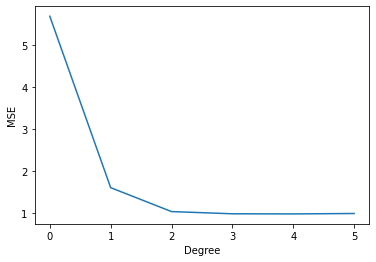

In [203]:
# Run the training with K-fold cross-validation
K = 4
max_degree = 5
test_points = 40


distance = compute_distance(x, y)
x_train, y_train, x_test, y_test = separate_test(distance, SNR, test_points)
best_model, results = k_fold_cross_validation(x_train, y_train, K, max_degree)
print(best_model)
plt.plot(range(max_degree + 1), results)
plt.xlabel('Degree')
plt.ylabel('MSE')
plt.show()


[-9.59798836e-08  2.24528135e-05 -2.35247271e-03  7.72888498e-02
  9.17714261e+00] 0.8626773240887926


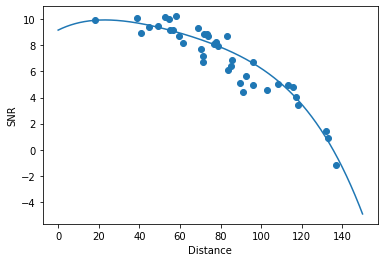

In [204]:
dist_vals = np.arange(0,150,0.1)
pred_SNR = np.zeros(1500)
for i in range(1500):
    pred_SNR[i] = predict(dist_vals[i], best_model)

print(best_model, evaluate(x_test, y_test, best_model))

plt.plot(dist_vals, pred_SNR)
plt.scatter(x_test, y_test)
plt.xlabel('Distance')
plt.ylabel('SNR')
plt.show()

---

## B. Tikhonov regularization

Change the loss function to include a Tikhonov regularization term, as an alternative to cross-validation (try $\lambda=0.01$)

In [205]:
def evaluate_tikhonov(x_train: np.ndarray, y_train: np.ndarray, lambda_par: float, max_degree: int) -> tuple[tuple, tuple]:
    results = []
    best = -1
    best_perf = 1e9
    for deg in range(max_degree + 1):
        k_model = np.polyfit(x_train, y_train, deg)
        loss = evaluate(x_train, y_train, k_model) # Empirical risk
        loss += np.sum(k_model ** 2) * lambda_par
        results.append(loss)
        if (best_perf > loss):
            best_perf = loss
            best = k_model
    return best, results

[6.196132522674841, 3.191226683735282, 1.7591446015002985, 2.1049087680141496, 1.7726948577617878, 1.7158099745481257]


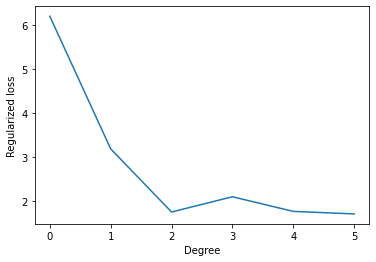

In [206]:
# Run the training with Tikhonov regularization and plot the loss as a function of the degree
max_degree = 5
test_points = 40
lambda_par = 0.01

distance = compute_distance(x, y)
best_model_tkh, results = evaluate_tikhonov(x_train, y_train, lambda_par, max_degree)
print(results)
plt.plot(range(max_degree + 1), results)
plt.xlabel('Degree')
plt.ylabel('Regularized loss')
plt.show()

## C. Minimum description length regularization

Change the loss function to include a representation length regularization term, as an alternative to cross-validation. The minimum description length of a polynomial of degree N is O(2^N) - try $\lambda=0.02$

In [207]:
def evaluate_representation(x_train: np.ndarray, y_train: np.ndarray, k: int, max_degree: int) -> tuple[tuple, tuple]:
    results = []
    best = -1
    best_perf = 1e9
    for deg in range(max_degree + 1):
        k_model = np.polyfit(x_train, y_train, deg)
        loss = evaluate(x_train, y_train, k_model) # Empirical risk
        loss += np.power(2, deg + 1) * lambda_par
        results.append(loss)
        if (best_perf > loss):
            best_perf = loss
            best = k_model
    return best, results

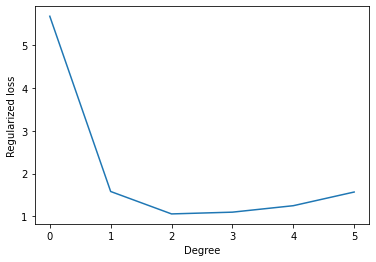

In [208]:
# Run the training with MDL regularization and plot the loss as a function of the degree
max_degree = 5
test_points = 40
lambda_par = 0.01

distance = compute_distance(x, y)
best_model_mdl, results = evaluate_representation(x_train, y_train, lambda_par, max_degree)

plt.plot(range(max_degree + 1), results)
plt.xlabel('Degree')
plt.ylabel('Regularized loss')
plt.show()

### TEST

Check the performance of the three solutions on the test set: which one does best?


[-9.59798836e-08  2.24528135e-05 -2.35247271e-03  7.72888498e-02
  9.17714261e+00] 0.8626773240887926


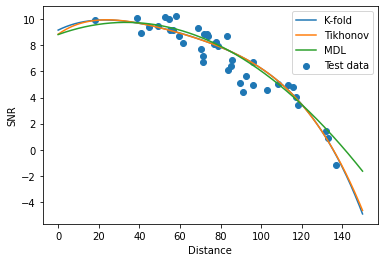

In [209]:
dist_vals = np.arange(0,150,0.1)
pred_SNR_Kfold = np.zeros(1500)
pred_SNR_tkh = np.zeros(1500)
pred_SNR_mdl = np.zeros(1500)
for i in range(1500):
    pred_SNR_Kfold[i] = predict(dist_vals[i], best_model)
    pred_SNR_tkh[i] = predict(dist_vals[i], best_model_tkh)
    pred_SNR_mdl[i] = predict(dist_vals[i], best_model_mdl)

print(best_model, evaluate(x_test, y_test, best_model))

plt.plot(dist_vals, pred_SNR_Kfold)
plt.plot(dist_vals, pred_SNR_tkh)
plt.plot(dist_vals, pred_SNR_mdl)
plt.scatter(x_test, y_test)
plt.xlabel('Distance')
plt.ylabel('SNR')
plt.legend(['K-fold','Tikhonov','MDL','Test data'])
plt.show()